In [1]:
using DrWatson

@quickactivate

In [2]:
# so we can keep adding packages to the venv
"""using Pkg
Pkg.add("SparseArrays")"""

"using Pkg\nPkg.add(\"SparseArrays\")"

In [3]:
using CairoMakie
using SparseArrays
using LinearAlgebra

In [4]:
using QuantumToolbox


In [12]:
N = 3 # local hilbert space dimension
L = 7 # size of the chain
ω = 1.0 # frequency of the harmonic oscillator
J = 0.5
γ = 0.1 # damping rate

"""a = destroy(N) # annihilation operator
a1 = tensor(a,  qeye(N), qeye(N))
a2 = tensor(qeye(N), a , qeye(N))
a3 = tensor(qeye(N),qeye(N),a)"""

#H = ω * a1' * a1 + ω * a2' * a2 + ω * a3' * a3  + J* (a1' * a2 + a2' * a3 + a3' * a2 + a2' * a1) 

"a = destroy(N) # annihilation operator\na1 = tensor(a,  qeye(N), qeye(N))\na2 = tensor(qeye(N), a , qeye(N))\na3 = tensor(qeye(N),qeye(N),a)"

In [13]:
# annihilation operator list
aj_list = []
a = destroy(N) # annihilation operator
# make sure we are type stable
sparseId = SparseMatrixCSC(Diagonal{ComplexF64}(ones(N)))
Id = QuantumObject(sparseId)

for i in range(1,L)
    local_list = fill(Id,L)
    local_list[i] = a
    # annihilation acting on j
    push!(aj_list,tensor(local_list ...));

end


In [14]:
H = ω*aj_list[1]' * aj_list[1] 

for i in range(2,L)
    H+= ω*aj_list[i]' * aj_list[i]  + J* (aj_list[i-1]' * aj_list[i]+ aj_list[i]' * aj_list[i-1])
end


In [15]:
# make sure we are type stable
sparseId = SparseMatrixCSC(Diagonal{ComplexF64}(ones(N)))
Id = QuantumObject(sparseId)
s_list = fill(fock(N,0),L)
s_list[1] = fock(N,2)
# ψ0 = tensor(fock(L, 2),fock(L,0),fock(L,0)) # initial state

ψ0 = tensor(s_list...); # initial state

In [16]:

c_ops = [sqrt(γ) * aj_list[end]]
e_ops = [aj_list[1]' * aj_list[1],aj_list[end]' * aj_list[end]]
tlist = range(0, 20, 100) # time list


result = mesolve(H, ψ0, tlist, c_ops, e_ops = e_ops)

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 57s (ETA: 0h 00m 00s)


Solution of time evolution
(return code: Success)
--------------------------
num_states = 1
num_expect = 2
ODE alg.: OrdinaryDiffEqTsit5.Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false))
abstol = 1.0e-8
reltol = 1.0e-6


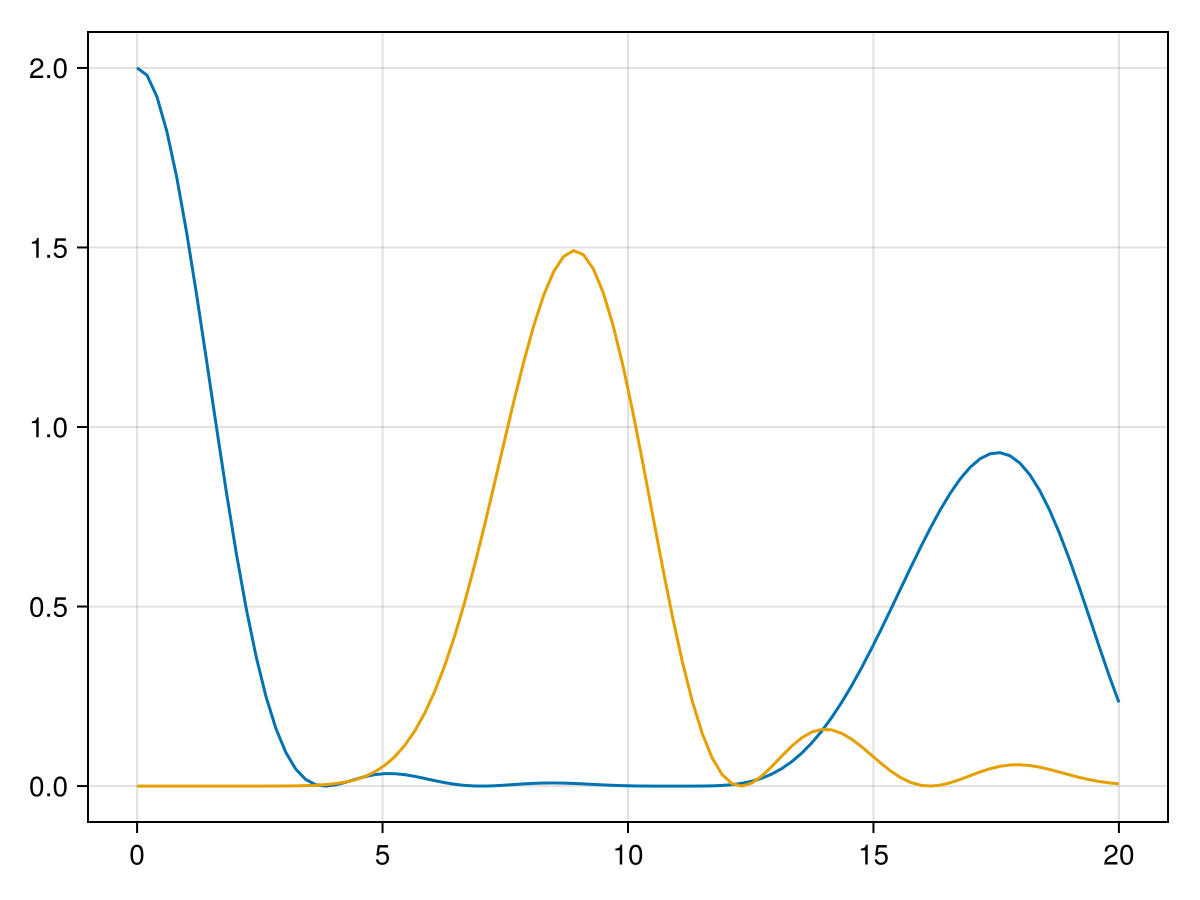

In [17]:
f = Figure()
ax = Axis(f[1, 1])

lines!(tlist, real(result.expect[1,1:end]))
lines!(tlist, real(result.expect[2,1:end]))


f